In [1]:
# Create GAN for independent and identically distributed data

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import secrets


class GAN:
    def __init__(self, P1 = 0.7, P2 = 0.4, seq_len=100, latent_dim = 200, n = 4):
        
        self.n = n
        self.P1 = np.random.rand(n)
        self.P2 = np.random.rand(n)
        self.P1 = self.P1 / np.sum(self.P1)
        self.P2 = self.P2 / np.sum(self.P2)
        # self.P1 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
        # self.P2 = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        seed = secrets.randbits(128)
        self.rng = np.random.default_rng(seed)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        print(self.P1)
        print(self.P2)
    
    def generate_real_samples(self, n_samples):
        X1 = self.rng.choice(self.n, (n_samples, self.seq_len, 1), p=self.P1)
        
        X2 = self.rng.choice(self.n, (n_samples, self.seq_len, 1), p=self.P2)
        
        X3 = (X1 + X2) % self.n
        
        X1 = tf.keras.utils.to_categorical(X1, self.n)
        X2 = tf.keras.utils.to_categorical(X2, self.n)
        X3 = tf.keras.utils.to_categorical(X3, self.n)
        X = np.concatenate((X1, X2, X3), axis=2)
        y = np.ones((n_samples, 1)) * 0.9
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, self.latent_dim)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        P1 = np.zeros(self.n)
        P2 = np.zeros(self.n)
        P3 = np.zeros(self.n)
        X1 = X[:,:,:self.n]
        X2 = X[:,:,self.n:2*self.n]
        X3 = X[:,:,2*self.n:]
        X1 = np.argmax(X1, axis=2)
        X2 = np.argmax(X2, axis=2)
        X3 = np.argmax(X3, axis=2)
        
        for i in range(self.n):
            P1[i] = np.sum(X1 == i)
            P2[i] = np.sum(X2 == i)
            P3[i] = np.sum(X3 == i)
        P1 = P1 / np.sum(P1)
        P2 = P2 / np.sum(P2)
        P3 = P3 / np.sum(P3)
        return P1, P2, P3
    
    def build_generator(self):
        # self.generator = tf.keras.models.Sequential([
        #     tf.keras.layers.Dense(self.seq_len * 200, input_shape=(self.latent_dim,)),
        #     tf.keras.layers.LeakyReLU(alpha=0.2),
        #     tf.keras.layers.Reshape((self.seq_len, 200)),
        #     tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.LSTM(100, return_sequences=True),
            # tf.keras.layers.Dense(10, activation='relu'),
            
        #     tf.keras.layers.Dense(3, activation='sigmoid'),
        # ])
        
        input = tf.keras.layers.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(self.seq_len * 200)(input)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Reshape((self.seq_len, 200))(x)
        x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
        y = tf.keras.layers.Dense(self.n * 3, activation='sigmoid')(x)
        # x1 = tf.keras.layers.Dense(self.n, activation='softmax')(x)
        # x2 = tf.keras.layers.Dense(self.n, activation='softmax')(x)
        # x3 = tf.keras.layers.Dense(self.n, activation='softmax')(x)
        # y = tf.keras.layers.Concatenate()([x1, x2, x3])
        self.generator = tf.keras.models.Model(inputs=input, outputs=y)
        
    def summarize_generator(self):
        self.generator.summary()

    def build_discriminator(self):
        # self.discriminator = tf.keras.models.Sequential([
        #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, input_shape=(self.seq_len, self.n * 3), return_sequences=True)),
        #     # tf.keras.layers.Dropout(0.5),
        #     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
        #     # tf.keras.layers.Dropout(0.5),
        #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
        #     # tf.keras.layers.Dropout(0.5),
        #     tf.keras.layers.Dense(1, activation='sigmoid'),
        # ])
        
        input = tf.keras.layers.Input(shape=(self.seq_len, self.n * 3))
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))(input)
        # x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))(x)
        # x = tf.keras.layers.Dropout(0.5)(x)
        # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False))(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        self.discriminator = tf.keras.models.Model(inputs=input, outputs=x)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
    
    def build_gan(self):
        self.discriminator.trainable = False
        input = self.generator.input
        output = self.discriminator(self.generator.output)
        self.gan = tf.keras.models.Model(inputs=input, outputs=output)
        self.gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
        
    def train(self, epochs = 10, batch_size = 128, data_size = 100000):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = data_size//batch_size
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(data_size)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, data_size, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)
                
                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(100000)
            print(calc_p)
            pred = self.generator.predict(np.random.normal(0, 1, (1, self.latent_dim)))
            X1 = pred[:,:,:self.n]
            X2 = pred[:,:,self.n:2*self.n]
            X3 = pred[:,:,2*self.n:]
            X1 = np.argmax(X1, axis=2)
            X2 = np.argmax(X2, axis=2)
            X3 = np.argmax(X3, axis=2)
            pred = np.concatenate((X1, X2, X3))
            # pred = np.concatenate((pred1, pred2, pred3))
            print(pred)
            # print(self.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

2024-02-23 13:51:48.777190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 13:51:51.184323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/TensorRT-8.4.0.6//lib:/usr/local/cuda-11.6/lib64:/usr/local/apps/python-3.10.2/lib:/usr/local/apps/cuDNN/8.4.0-cuda-11.6/lib
2024-02-23 13:51:51.184471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

In [2]:
gan = GAN()
gan.summarize_generator()
gan.summarize_discriminator()

# print(.shape)

2024-02-23 13:51:55.749471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 13:51:56.363680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9626 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


[0.45861504 0.19451346 0.0317875  0.31508399]
[0.10477255 0.29035858 0.30425484 0.30061403]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 20000)             4020000   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20000)             0         
                                                                 
 reshape (Reshape)           (None, 100, 200)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 100)          120400    
                                                                 
 dense_1 (Dense)             (None, 100, 12)           1212      
                                   

In [3]:
print(gan.generate_real_samples(1))

(array([[[0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32), array([[0.9]]))


Iteration: 0


2024-02-23 13:52:01.314494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2024-02-23 13:52:05.785378: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x14e228038940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 13:52:05.785428: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-23 13:52:05.791540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-23 13:52:05.947661: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(array([7.857666e-01, 1.740000e-05, 0.000000e+00, 2.142160e-01]), array([0.       , 0.4701167, 0.3891943, 0.140689 ]), array([0.0007995, 0.7875427, 0.2116578, 0.       ]))
[[0 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
  1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]


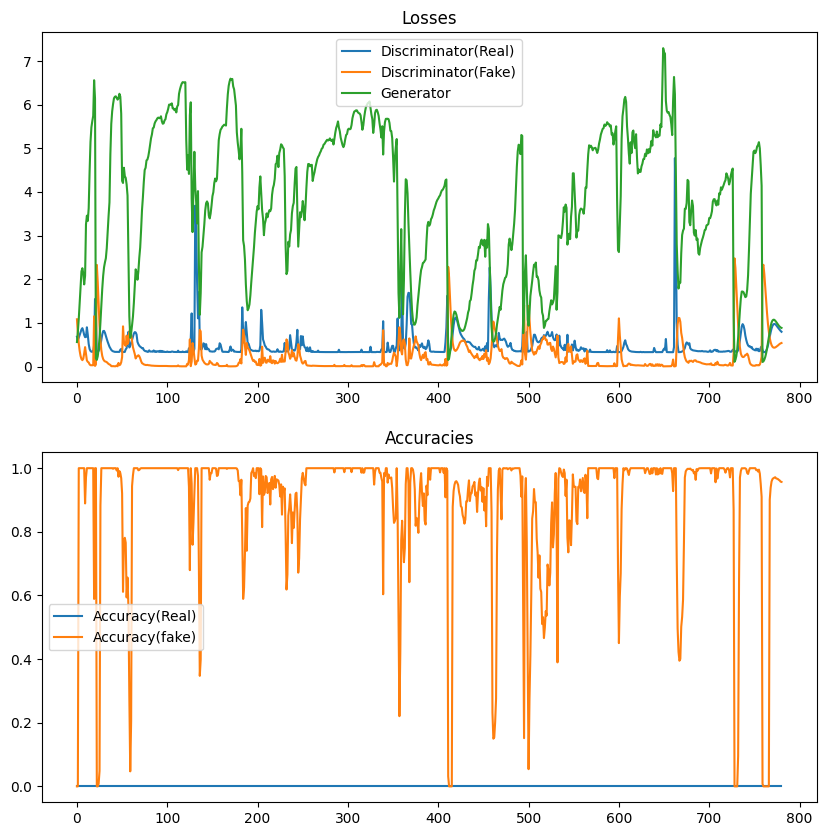

Iteration: 1
(array([0.6000271, 0.1812087, 0.       , 0.2187642]), array([7.000000e-07, 9.269000e-04, 1.900100e-03, 9.971723e-01]), array([6.300000e-05, 1.114670e-02, 9.853744e-01, 3.415900e-03]))
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0 0 0]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]


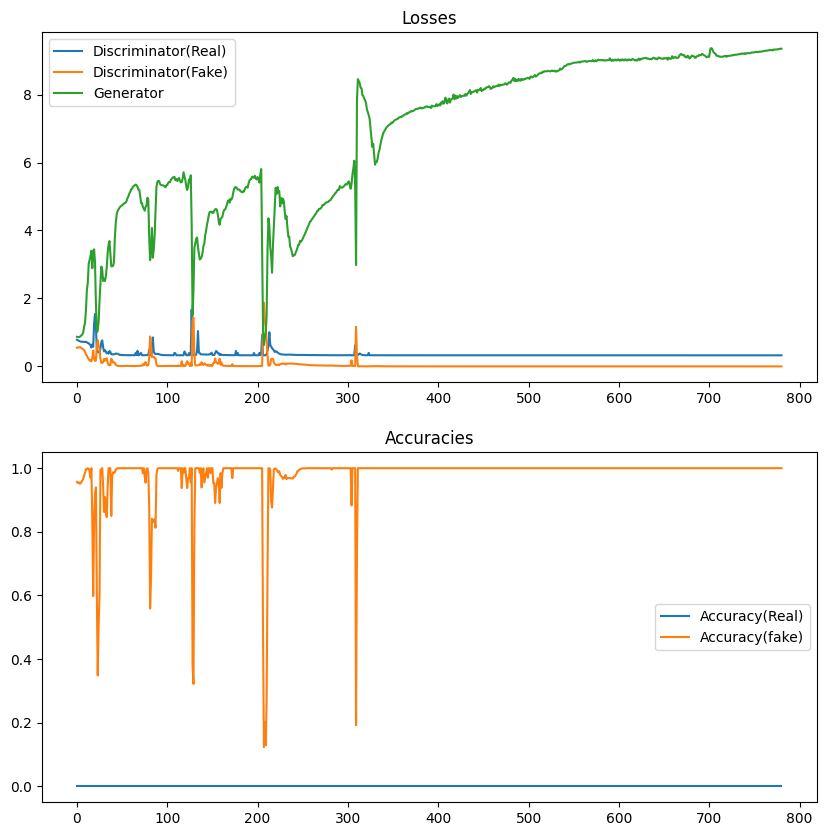

Iteration: 2
(array([9.967311e-01, 2.050000e-05, 2.478000e-04, 3.000600e-03]), array([2.859000e-04, 3.080162e-01, 2.174319e-01, 4.742660e-01]), array([4.111000e-04, 4.456760e-02, 1.326608e-01, 8.223605e-01]))
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 3 3 3 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 3 3 3 3 3 3 3 3 3 3 3 3]
 [1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 1 1 3 3 3 3 2 2 2 2 3 3 3 3 3 3 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]


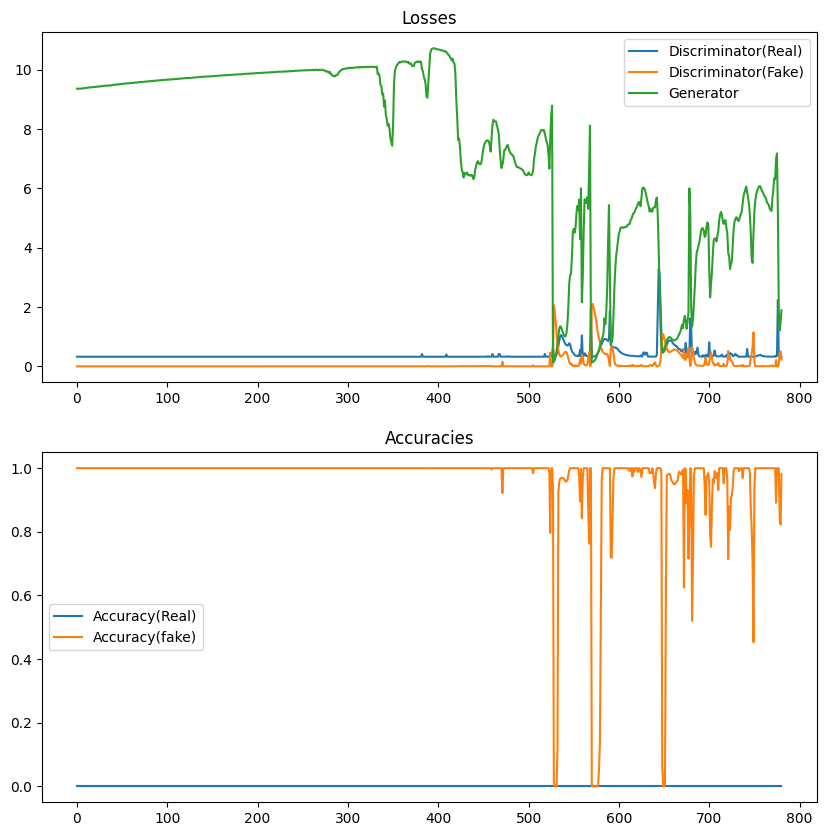

Iteration: 3
(array([0.3258185, 0.2388671, 0.0117998, 0.4235146]), array([0.0009885, 0.2240148, 0.3649153, 0.4100814]), array([0.0873006, 0.3171886, 0.2976787, 0.2978321]))
[[0 1 3 3 3 0 1 3 3 0 0 1 3 3 0 1 2 3 3 3 0 1 3 3 3 3 0 1 3 3 3 0 0 1 3 3
  0 0 1 3 3 0 0 1 3 3 0 0 1 3 3 3 0 0 1 3 0 0 1 3 3 0 0 1 3 3 3 0 0 1 3 3
  3 0 0 1 3 3 3 0 1 3 3 3 0 1 1 3 3 0 0 1 3 3 0 0 1 3 3 3]
 [3 3 2 2 2 3 3 2 2 1 3 3 2 1 1 3 3 2 2 1 1 3 2 2 2 1 3 3 2 2 2 1 3 3 3 2
  1 3 3 3 2 1 3 3 2 2 1 3 3 2 2 1 1 3 3 2 1 3 3 2 2 1 3 3 3 2 1 1 3 3 2 2
  1 1 3 3 2 2 2 1 3 2 2 1 1 3 3 2 2 1 3 3 2 2 1 3 3 2 2 1]
 [3 3 2 2 1 1 3 2 2 1 3 0 2 1 1 3 0 2 2 1 1 3 2 2 2 1 1 3 2 2 2 1 1 3 0 0
  1 3 3 0 2 1 3 3 2 2 1 3 3 2 2 1 1 1 3 2 1 1 3 2 2 1 1 3 0 2 1 1 3 3 2 2
  1 1 3 3 2 2 1 1 3 2 2 1 1 3 3 2 2 1 3 3 2 2 1 3 3 2 0 1]]


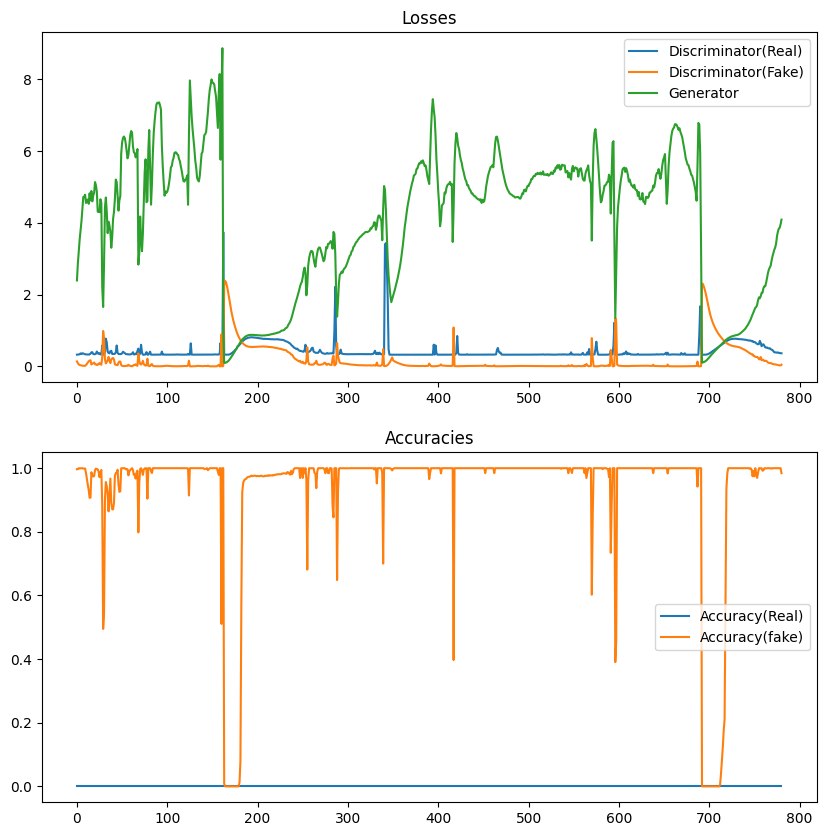

Iteration: 4
(array([4.072260e-01, 2.068443e-01, 1.000000e-07, 3.859296e-01]), array([0.0478966, 0.4889249, 0.2772395, 0.185939 ]), array([0.2229109, 0.5344041, 0.0778297, 0.1648553]))
[[1 0 3 3 0 1 3 3 3 3 3 3 3 3 1 3 3 3 3 3 1 1 3 3 3 1 0 0 3 0 3 3 1 3 3 3
  0 1 3 3 0 1 0 0 3 1 3 3 3 1 0 3 3 1 3 3 3 1 3 3 3 1 1 0 0 0 0 3 1 0 0 3
  3 3 1 0 0 3 3 1 0 0 3 3 1 1 0 0 3 3 3 1 1 0 0 3 0 1 0 0]
 [3 2 2 1 2 1 1 1 1 1 1 1 1 1 3 0 1 1 1 1 0 3 1 1 1 3 2 2 1 1 1 1 0 1 1 1
  1 3 1 1 1 3 2 1 1 0 1 1 1 3 2 1 1 0 1 1 1 3 1 1 1 3 2 2 2 2 1 1 3 2 2 1
  1 1 3 2 2 1 1 3 2 2 1 1 3 3 2 1 1 1 1 0 2 2 1 1 1 3 2 2]
 [0 3 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 3 1 1 1 1 0 0 0 0 1
  1 3 0 1 1 3 2 1 0 0 0 0 0 3 2 1 1 0 0 1 1 0 0 1 1 3 3 1 1 1 1 1 3 3 1 1
  1 0 3 2 1 1 1 3 1 1 1 1 0 3 2 1 1 0 0 0 3 1 1 1 1 3 2 1]]


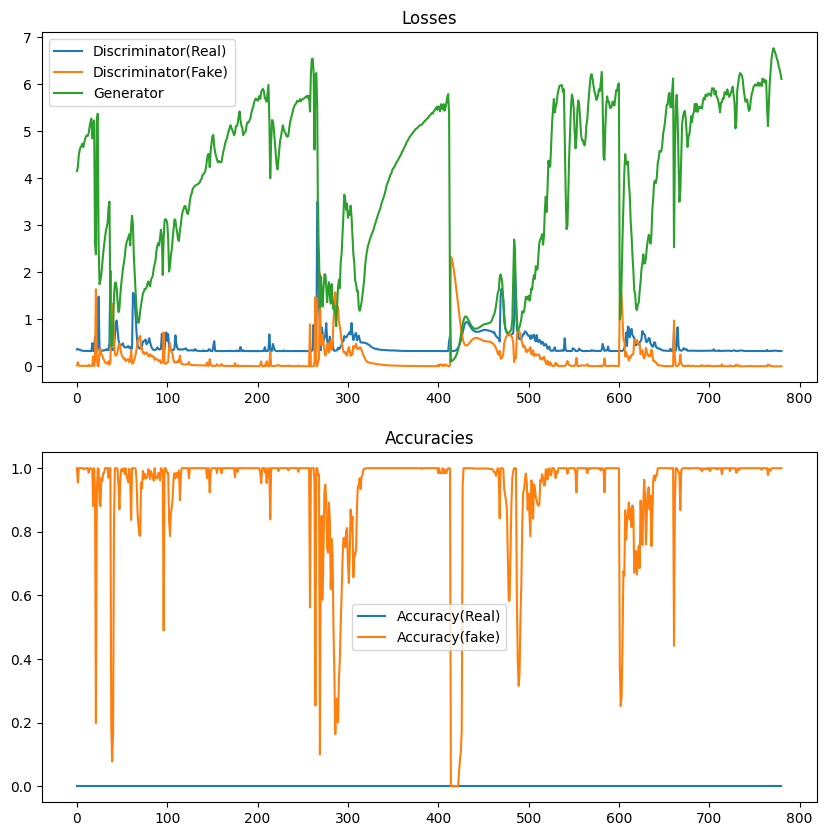

Iteration: 5
(array([5.721259e-01, 2.430282e-01, 8.400000e-06, 1.848375e-01]), array([0.0792856, 0.5018489, 0.2078105, 0.211055 ]), array([0.3114873, 0.2329404, 0.1826   , 0.2729723]))
[[3 3 3 3 1 1 3 0 3 1 1 0 0 1 1 1 1 0 3 3 1 0 0 0 1 0 0 0 0 3 1 0 0 3 1 0
  0 0 0 3 3 1 1 1 3 1 0 0 0 3 1 1 0 0 0 1 1 1 0 0 3 1 3 0 3 3 1 0 0 3 3 1
  0 0 0 3 1 0 0 0 3 3 0 0 0 3 3 3 0 0 0 1 0 0 0 1 0 0 3 1]
 [1 0 2 1 0 0 2 1 1 3 2 2 1 1 0 0 3 1 1 1 0 2 1 1 3 3 2 1 1 0 3 2 1 1 3 3
  2 1 1 0 2 1 0 0 2 0 3 2 1 1 0 2 2 1 1 0 2 2 2 1 1 0 2 2 1 1 3 2 1 1 1 1
  3 2 1 1 1 3 2 1 1 1 3 2 1 1 1 1 2 1 1 0 2 2 1 1 2 1 1 3]
 [0 0 2 0 0 2 2 2 1 0 3 2 1 0 0 0 3 2 0 0 3 3 1 1 3 3 2 1 0 0 3 2 1 0 3 3
  2 1 1 0 2 0 0 0 2 0 3 2 1 0 0 2 2 2 0 0 0 2 2 0 0 0 2 2 0 0 3 3 1 0 0 0
  3 2 1 0 0 3 3 1 0 0 3 2 1 0 0 0 3 1 1 0 2 2 0 0 3 1 0 3]]


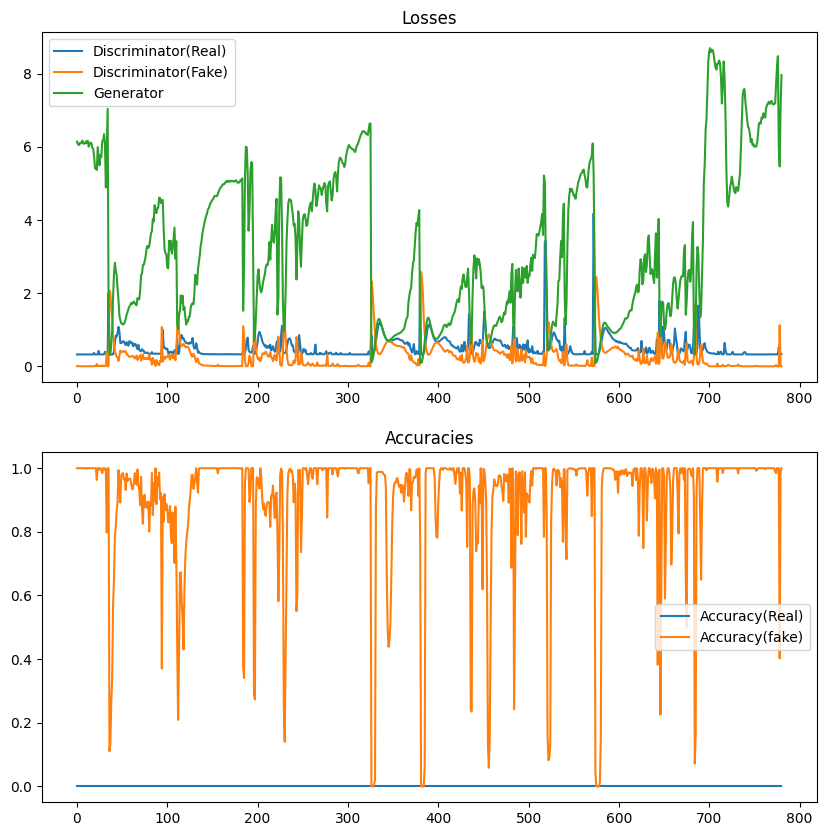

Iteration: 6
(array([0.486241 , 0.4473189, 0.0138856, 0.0525545]), array([0.0035509, 0.208873 , 0.0226315, 0.7649446]), array([0.2967743, 0.0201422, 0.3020844, 0.3809991]))
[[0 0 1 1 3 3 1 0 0 1 1 1 2 1 0 0 2 3 2 2 2 2 3 3 1 1 0 0 0 3 3 3 2 2 2 1
  1 0 0 0 3 3 3 1 3 3 3 3 3 2 0 2 3 3 3 3 1 0 0 1 1 0 0 0 3 3 3 1 1 0 0 0
  1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0]
 [1 1 1 3 2 2 3 3 1 1 3 3 3 3 3 1 1 1 1 1 1 1 1 2 2 2 3 3 1 1 3 2 3 3 1 2
  2 3 3 1 1 1 1 0 1 0 1 1 1 3 0 1 1 2 2 2 3 3 3 1 3 3 3 1 1 1 2 2 3 3 3 1
  3 3 3 1 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 1 3 3 3]
 [1 1 0 3 0 2 2 3 0 0 2 2 2 0 3 0 0 0 0 0 1 1 1 1 2 2 3 3 0 0 0 2 3 2 1 2
  2 3 3 0 0 0 0 0 0 0 1 1 1 3 3 1 0 0 1 1 3 3 3 0 2 3 3 0 0 0 2 2 3 3 3 0
  2 3 3 0 0 3 3 3 0 2 2 3 3 3 0 0 2 3 3 0 0 2 3 3 0 2 2 3]]


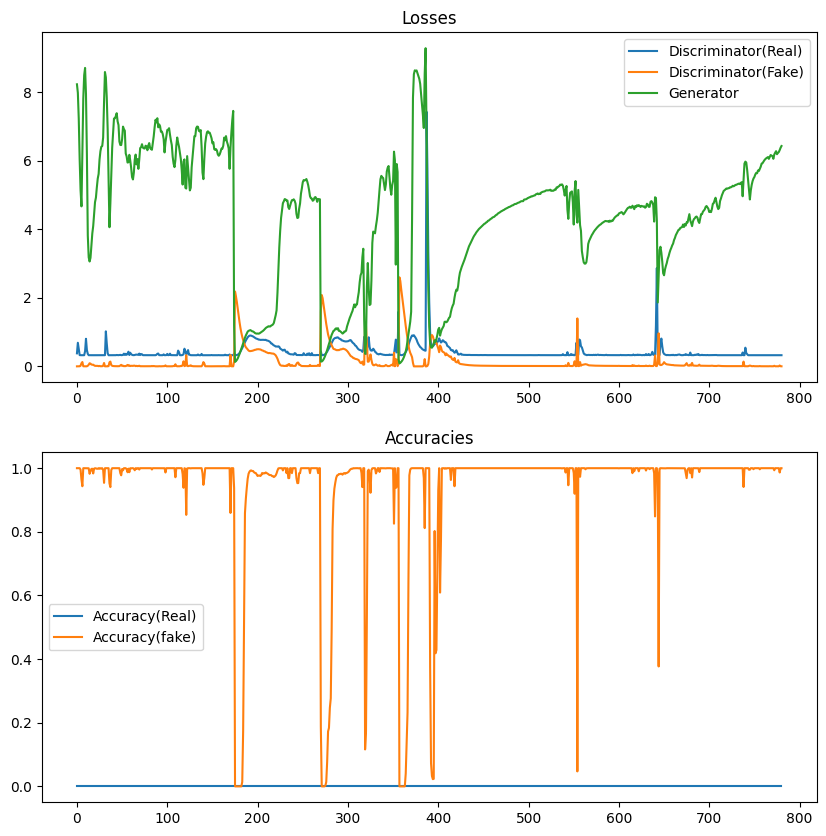

Iteration: 7
(array([6.916343e-01, 2.087904e-01, 1.300000e-06, 9.957400e-02]), array([0.1824205, 0.1878527, 0.3061146, 0.3236122]), array([0.1049997, 0.2247853, 0.3721094, 0.2981056]))
[[0 0 0 1 1 0 0 0 1 0 0 0 3 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 3
  0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0
  0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 3 3 0 1 1 0 0 0 0 1 0]
 [2 2 2 1 1 2 2 3 3 0 2 2 3 2 0 2 2 3 2 2 3 3 3 2 3 2 3 1 0 2 3 3 2 2 2 3
  2 3 3 2 3 3 2 1 3 3 2 2 3 2 3 1 2 3 3 2 0 2 3 3 2 3 3 1 2 2 3 1 1 0 2 3
  3 2 3 3 3 1 1 2 2 3 1 2 2 2 2 3 0 1 2 2 3 3 1 0 2 2 3 1]
 [2 2 2 0 0 2 2 2 0 3 1 2 2 3 3 2 2 0 2 3 2 2 2 1 3 2 2 0 1 1 2 2 1 2 2 2
  1 3 2 2 3 3 2 3 2 2 2 3 2 2 2 3 2 2 2 1 3 2 2 2 1 2 2 3 1 1 2 3 0 1 1 2
  2 1 2 2 2 3 1 2 2 2 0 1 2 2 3 2 3 0 1 2 2 3 3 3 2 2 2 3]]


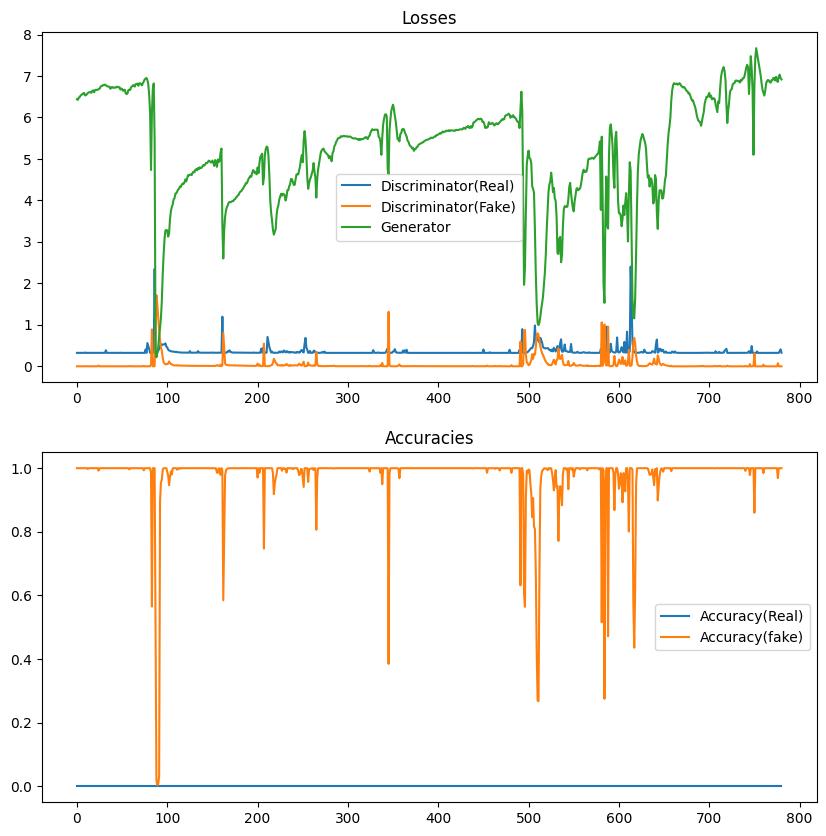

Iteration: 8
(array([5.511922e-01, 1.646673e-01, 1.322000e-04, 2.840083e-01]), array([0.3424882, 0.0701752, 0.5817632, 0.0055734]), array([0.16437  , 0.03561  , 0.4105107, 0.3895093]))
[[0 0 0 0 3 3 0 0 1 3 0 0 0 0 1 1 1 0 3 3 0 0 0 3 1 0 0 0 1 1 0 3 1 0 0 1
  1 0 0 1 1 0 3 0 3 0 0 1 0 0 3 1 1 3 0 0 1 3 0 3 1 0 0 0 0 1 0 0 3 3 3 3
  0 3 1 0 0 3 1 0 0 0 0 1 3 0 0 0 1 0 0 0 0 3 1 1 0 0 3 3]
 [2 2 0 0 0 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 0 0 2 2 2 2 2 1 2 2 0
  1 1 2 2 2 2 2 0 0 2 0 0 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 0 2 2 2 0 0
  0 0 0 0 2 2 2 1 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 0 2 2 2]
 [2 2 3 3 0 0 3 2 3 0 2 2 2 2 2 2 3 1 2 2 3 3 0 2 0 3 3 2 2 2 3 0 0 2 2 0
  0 3 2 3 1 2 2 3 0 2 3 0 1 2 2 2 3 2 2 2 3 2 3 0 2 3 2 2 2 3 3 2 2 0 0 3
  3 0 0 3 2 2 3 1 3 3 2 2 2 3 2 2 3 3 3 3 2 2 2 3 3 3 2 2]]


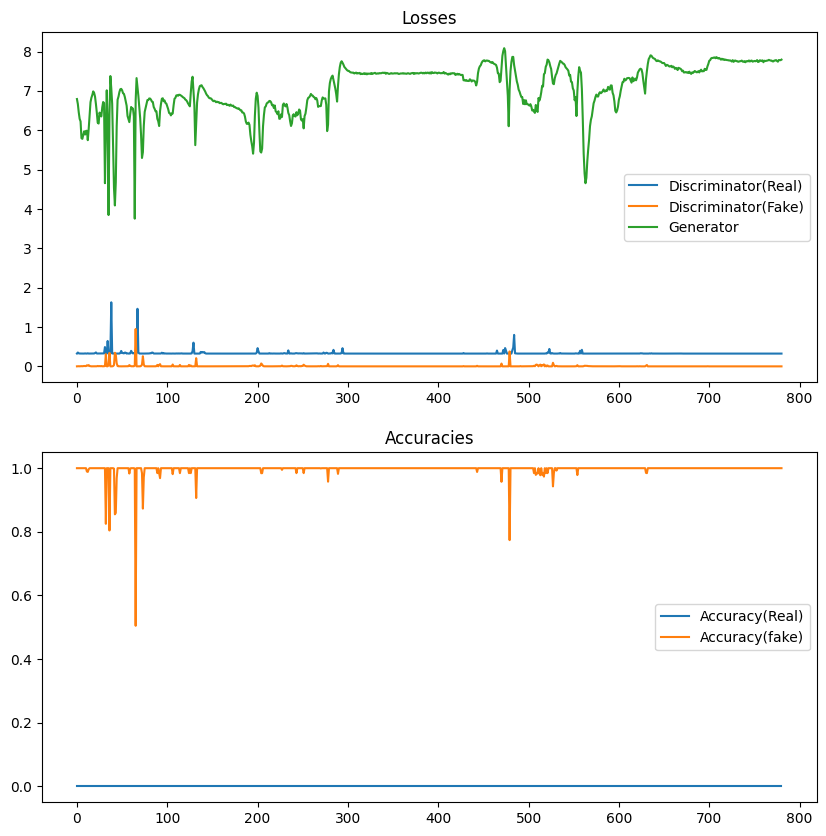

Iteration: 9
(array([0.2927858, 0.395444 , 0.0010554, 0.3107148]), array([0.1015387, 0.4248539, 0.2937253, 0.1798821]), array([0.3224804, 0.1676717, 0.3576162, 0.1522317]))
[[3 0 0 3 1 1 3 3 0 1 1 0 1 1 3 3 0 0 1 1 3 0 1 3 3 0 0 1 1 0 0 1 1 3 3 3
  1 3 1 1 3 0 0 1 1 3 0 1 3 3 1 0 3 1 1 1 3 3 0 1 3 3 3 1 1 3 0 1 1 1 3 3
  1 1 3 0 1 1 3 3 0 0 1 1 1 0 0 1 1 3 3 1 1 1 3 3 0 1 1 3]
 [3 3 1 1 2 3 1 1 3 2 1 1 2 2 3 1 1 1 2 1 1 2 2 2 1 0 0 2 2 1 3 2 1 1 1 3
  3 1 2 2 1 1 3 2 1 1 2 3 1 1 2 0 0 2 2 3 1 1 1 2 3 1 1 2 3 1 1 2 2 2 1 0
  2 1 1 1 2 1 1 1 0 0 2 2 1 1 2 2 0 1 1 2 2 1 1 1 1 2 2 1]
 [2 3 3 0 2 3 0 2 3 2 1 1 2 2 1 0 1 2 2 0 0 2 2 0 0 0 3 2 1 1 2 2 0 0 0 2
  3 0 2 3 0 1 2 2 0 0 2 3 0 2 1 0 0 2 2 3 0 0 0 2 3 0 0 2 3 0 1 2 2 1 0 0
  2 0 0 2 2 1 0 0 3 3 2 2 0 1 2 2 3 0 0 2 2 1 0 0 2 2 1 0]]


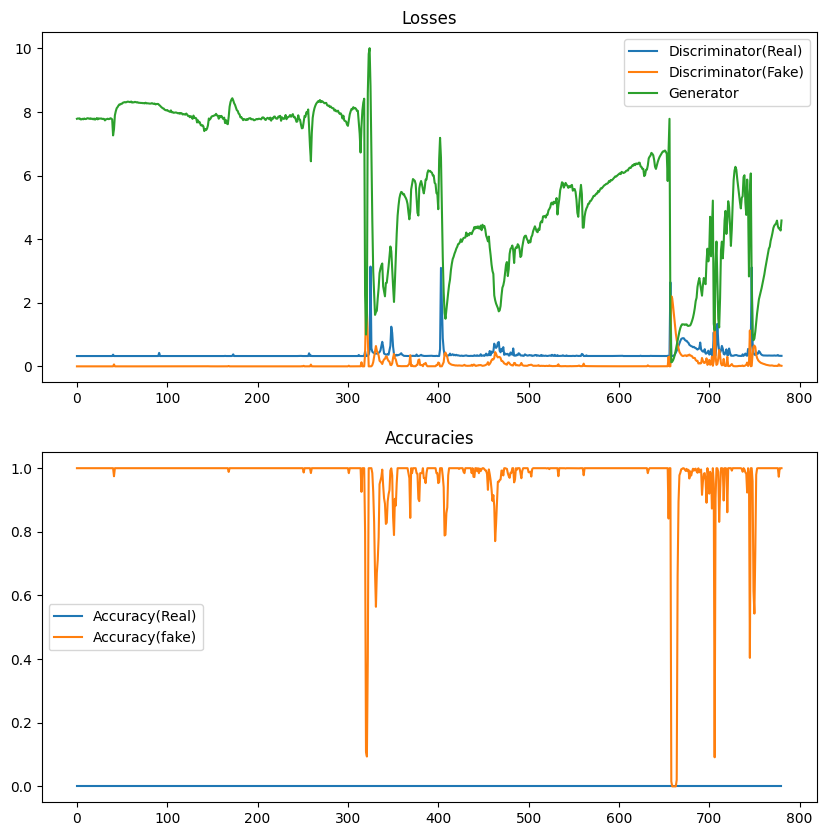

In [4]:
tf.keras.utils.disable_interactive_logging()
gan.train(epochs=10)

In [6]:
x, _ = gan.generate_real_samples(1)
print(x[0][0][:4])
print(x[0][0][4:8])
print(x[0][0][8:])

[0. 0. 0. 1.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]


In [8]:
x = gan.generator.predict(np.random.normal(0, 1, (1, gan.latent_dim)))
print(x[0][0][:4], np.argmax(x[0][0][:4]))
print(x[0][0][4:8], np.argmax(x[0][0][4:8]))
print(x[0][0][8:], np.argmax(x[0][0][8:]))

[0.00097167 0.00096805 0.00384522 0.9484914 ] 3
[0.0014678  0.00022169 0.01308145 0.18818997] 3
[0.00291037 0.00043156 0.09952481 0.00671   ] 2


In [24]:
x = gan.generator.predict(np.random.normal(0, 1, (10000, gan.latent_dim)))
X1 = x[:,:,:4]
X2 = x[:,:,4:8]
X3 = x[:,:,8:]



In [25]:
print(x.shape,X1.shape, X2.shape,X3.shape)

(10000, 100, 12) (10000, 100, 4) (10000, 100, 4) (10000, 100, 4)
